<a href="https://colab.research.google.com/github/kanishquetyagi/Company-Bankruptcy-Prediction/blob/main/COMPANY_BANKRUPTCY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
path = '/content/drive/MyDrive/AlmaBetter/Team Capstone Projects/Supervised ML (Classification) - COMPANY BANKRUPTCY PREDICTION/COMPANY BANKRUPTCY PREDICTION.csv'
df = pd.read_csv(path)
# df=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4 - ML/Week 1/Datasets/COMPANY BANKRUPTCY PREDICTION.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
pd.options.display.float_format = '{:,.6f}'.format
from imblearn.ensemble import BalancedBaggingClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


#Initial EDA

In [ ]:
df.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.000000,0.458143,0.000725,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,"4,980,000,000.000000",0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,"701,000,000.000000","6,550,000,000.000000",0.593831,"458,000,000.000000",0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.000000,0.461867,0.000647,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,"6,110,000,000.000000",0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,0.001384,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,0.000107,"7,700,000,000.000000",0.593916,"2,490,000,000.000000",0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,0.000236,"25,500,000.000000",0.458521,0.000790,0.000000,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,"7,280,000,000.000000",0.0003

In [ ]:
df.shape

(6819, 96)

**Dataset is consist of 6819 rows and 96 features including the dependent variable**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,"6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000",...,"6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000"
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,"1,995,347,312.802792","1,950,427,306.056799",0.467431,"16,448,012.905942",0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,"1,328,640.602096",0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,"5,508,096,595.248731","1,566,212.055241",0.264248,0.379677,"403,284.954245","8,376,594.819685",0.630991,"4,416,336.714259",0.113177,0.886823,0.008783,...,0.522273,0.124095,"3,592,902.196830","37,159,994.147133",0.090673,0.353828,0.277395,"55,806,804.525780",0.761599,0.73581

<h2> Checking for Missing Values

In [ ]:
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [ ]:
df.isnull().sum().sum()

0

**There are no missing values in our dataset i.e 0 Non-Null value**

In [ ]:
df.duplicated().sum()

0

**There are no duplicated values in the dataset as well.**

# <h2>Checking for Categorical features with less than equal to 10 categories.

In [ ]:
#creating a for loop to get the categorical columns with 10 or less than 10 unique values
list_1=[]
for i in df.columns:
  x=df[i].value_counts()
  if len(x)<=15:
    list_1.append(i)
  else:
    continue
list_1

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']

**We've found only 2 categorical features.**

In [ ]:
df[' Liability-Assets Flag'].value_counts()

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64

**Liability-Assets Flag consist of 2 unique values with high imabalance**

In [ ]:
df[' Net Income Flag'].value_counts()

1    6819
Name:  Net Income Flag, dtype: int64

**Net Income Flag consist of only 1 unique values. Hence, we're dropping both categorical features.**

In [ ]:
df.drop(columns=[' Net Income Flag', ' Liability-Assets Flag'],inplace=True)

In [ ]:
df.shape

(6819, 94)

# <h2> Handling Outliers

In [ ]:
columns = df.columns[1:].tolist()

In [ ]:
# df1 = df.iloc[:,1:].copy()
# X = df1
# Y = df['Bankrupt?']

In [ ]:
# #X.columns.tolist()
# Y.value_counts()

In [ ]:
# Q3 = X.quantile(0.75)
# Q1 = X.quantile(0.25)
# IQR = Q3 - Q1
# X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
# df['Bankrupt?'].value_counts()

Tried Removing Outlier but won't work in this case due to huge no of features.

##<h2>Capping Outliers

In [ ]:
for col in columns:
  Q3 = df[col].quantile(0.75)
  Q1 = df[col].quantile(0.25)
  IQR = Q3 - Q1
  df.loc[(df[col] > Q3 + (1.5*IQR)),col] = Q3 
  df.loc[(df[col] < Q1 - (1.5*IQR)),col] = Q1

In [ ]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

## <h2> Bivariate Analysis

<h3> Between Independent and Dependent Variable

<Figure size 648x432 with 0 Axes>

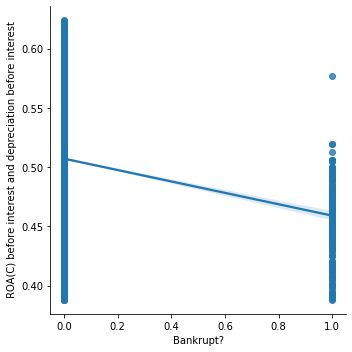

<Figure size 648x432 with 0 Axes>

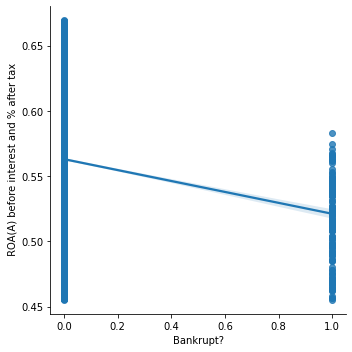

<Figure size 648x432 with 0 Axes>

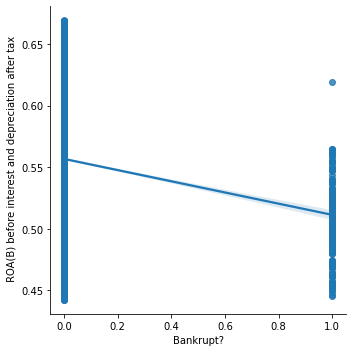

<Figure size 648x432 with 0 Axes>

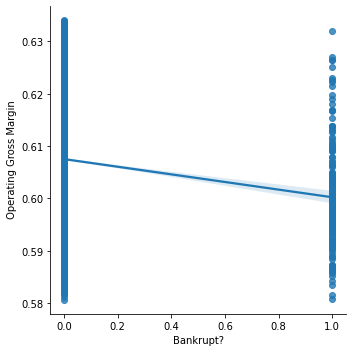

<Figure size 648x432 with 0 Axes>

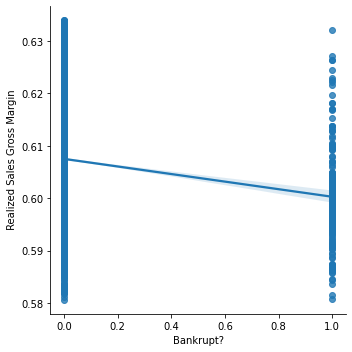

<Figure size 648x432 with 0 Axes>

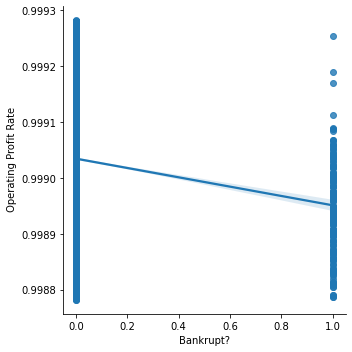

<Figure size 648x432 with 0 Axes>

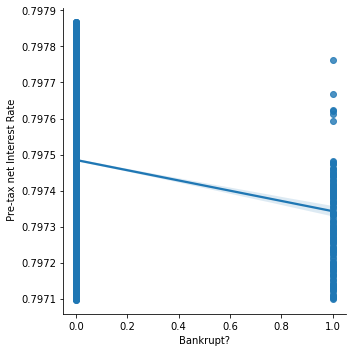

<Figure size 648x432 with 0 Axes>

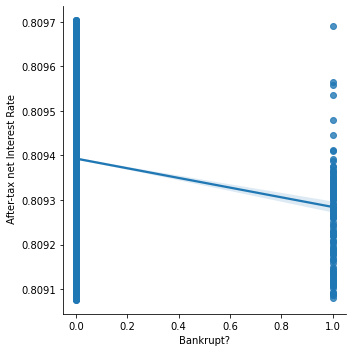

<Figure size 648x432 with 0 Axes>

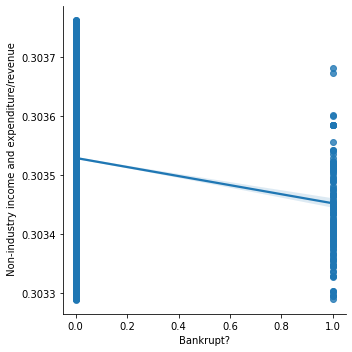

<Figure size 648x432 with 0 Axes>

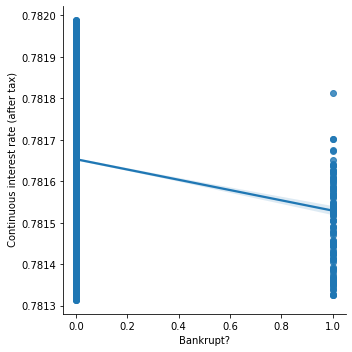

<Figure size 648x432 with 0 Axes>

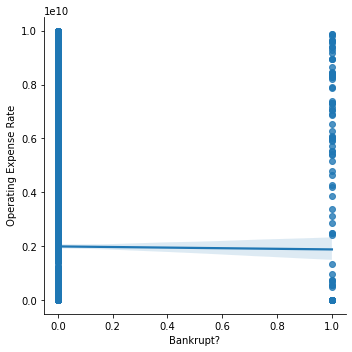

<Figure size 648x432 with 0 Axes>

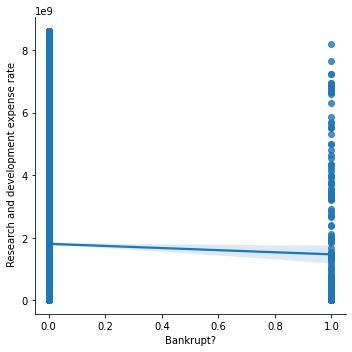

<Figure size 648x432 with 0 Axes>

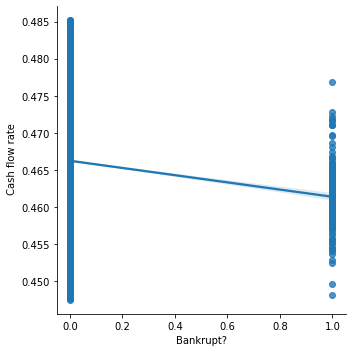

<Figure size 648x432 with 0 Axes>

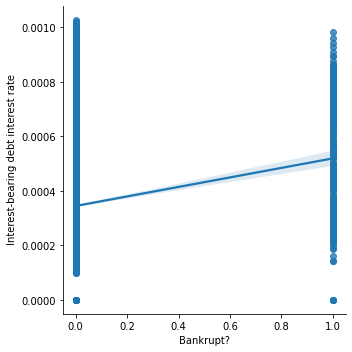

<Figure size 648x432 with 0 Axes>

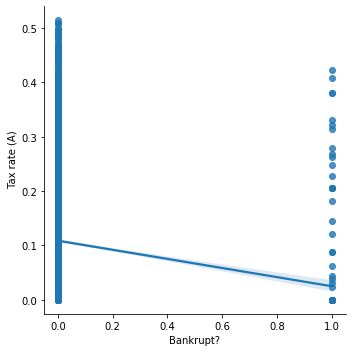

<Figure size 648x432 with 0 Axes>

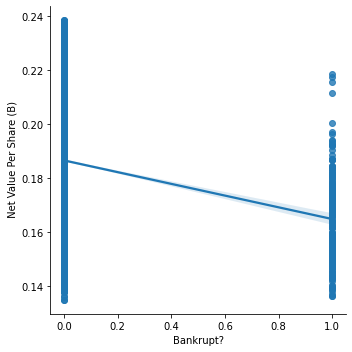

<Figure size 648x432 with 0 Axes>

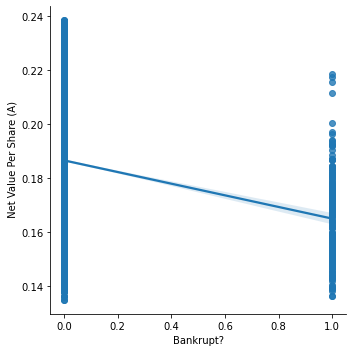

<Figure size 648x432 with 0 Axes>

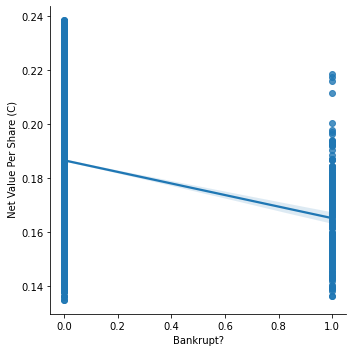

<Figure size 648x432 with 0 Axes>

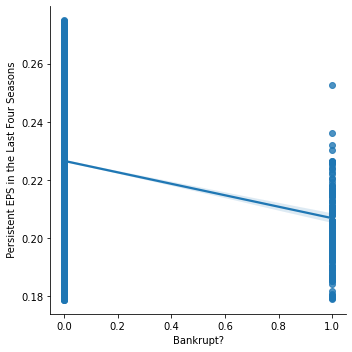

<Figure size 648x432 with 0 Axes>

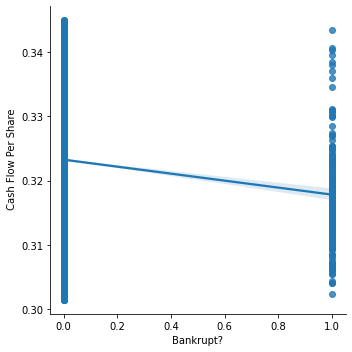

<Figure size 648x432 with 0 Axes>

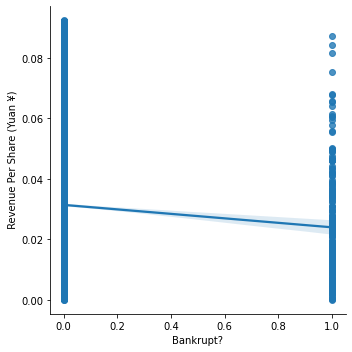

<Figure size 648x432 with 0 Axes>

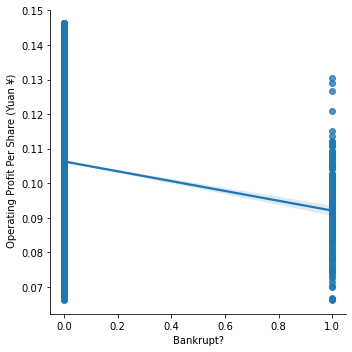

<Figure size 648x432 with 0 Axes>

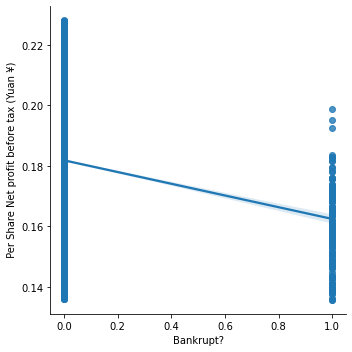

<Figure size 648x432 with 0 Axes>

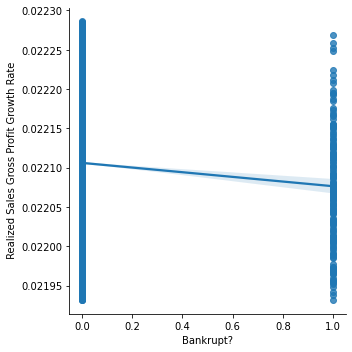

<Figure size 648x432 with 0 Axes>

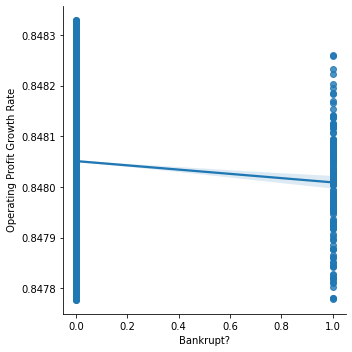

<Figure size 648x432 with 0 Axes>

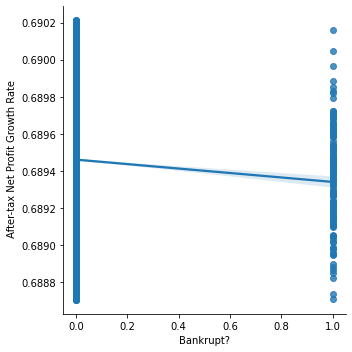

<Figure size 648x432 with 0 Axes>

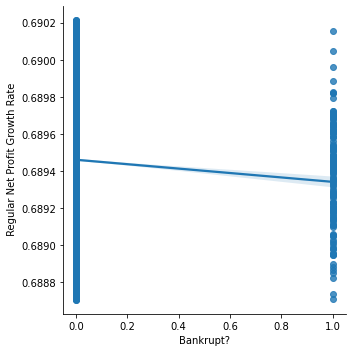

<Figure size 648x432 with 0 Axes>

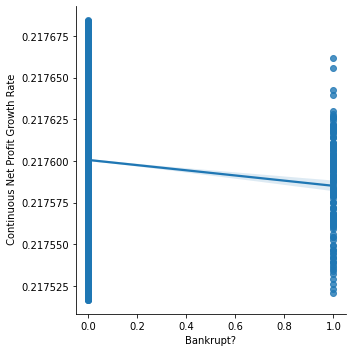

<Figure size 648x432 with 0 Axes>

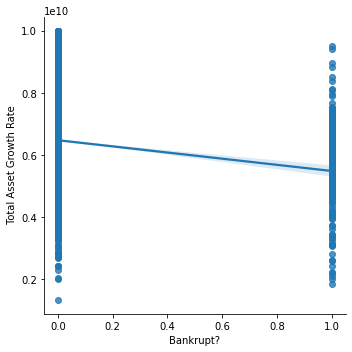

<Figure size 648x432 with 0 Axes>

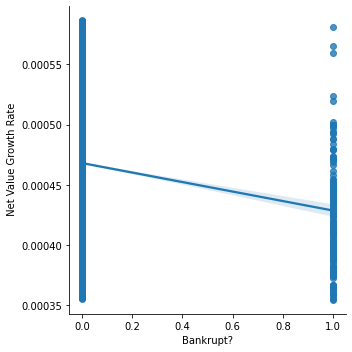

<Figure size 648x432 with 0 Axes>

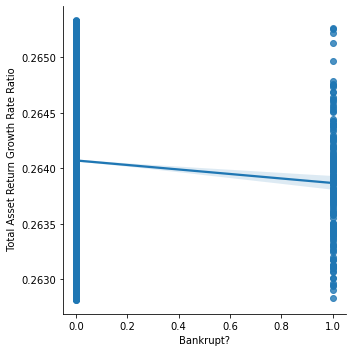

<Figure size 648x432 with 0 Axes>

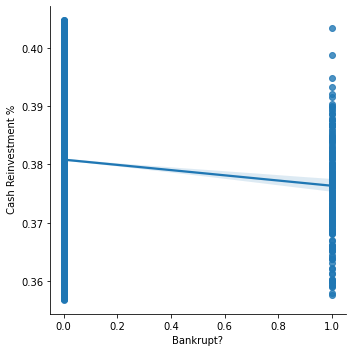

<Figure size 648x432 with 0 Axes>

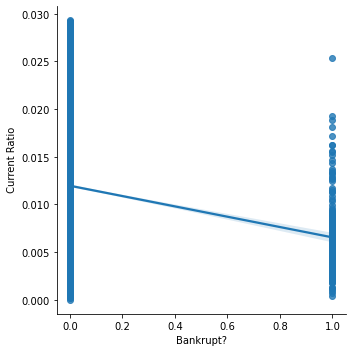

<Figure size 648x432 with 0 Axes>

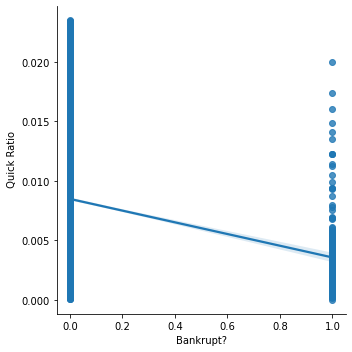

<Figure size 648x432 with 0 Axes>

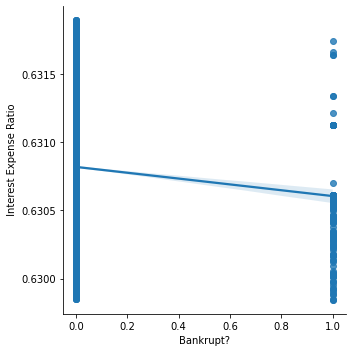

<Figure size 648x432 with 0 Axes>

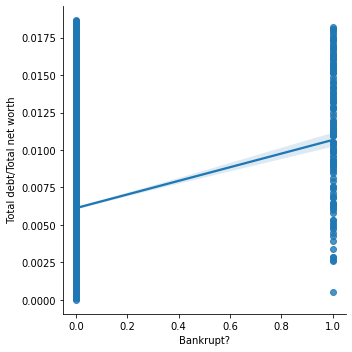

<Figure size 648x432 with 0 Axes>

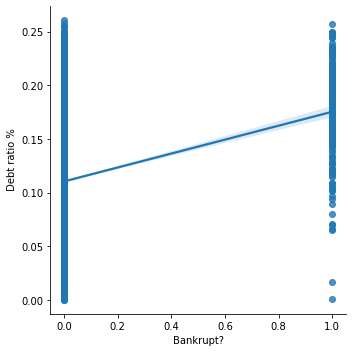

<Figure size 648x432 with 0 Axes>

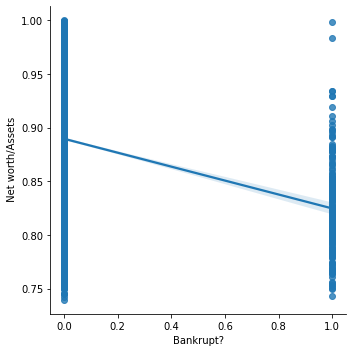

<Figure size 648x432 with 0 Axes>

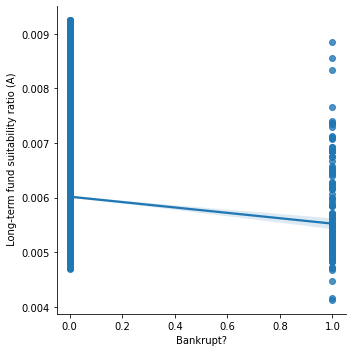

<Figure size 648x432 with 0 Axes>

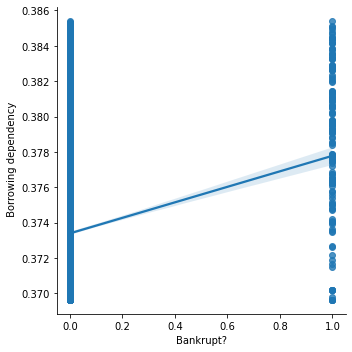

<Figure size 648x432 with 0 Axes>

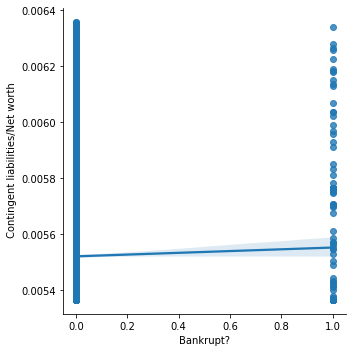

<Figure size 648x432 with 0 Axes>

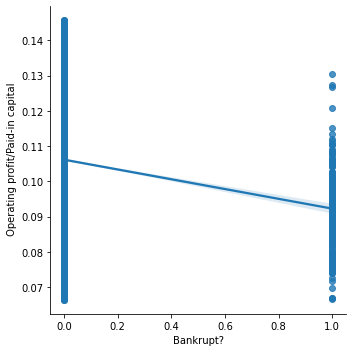

<Figure size 648x432 with 0 Axes>

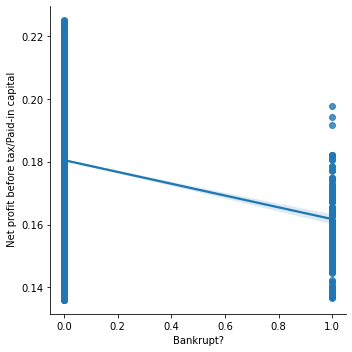

<Figure size 648x432 with 0 Axes>

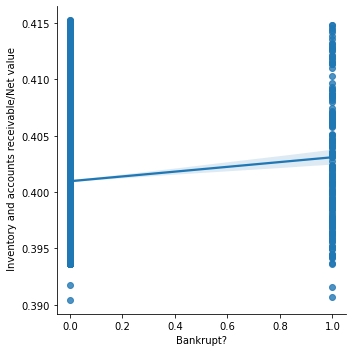

<Figure size 648x432 with 0 Axes>

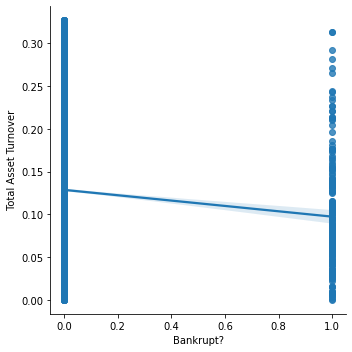

<Figure size 648x432 with 0 Axes>

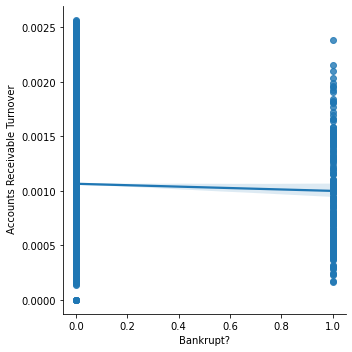

<Figure size 648x432 with 0 Axes>

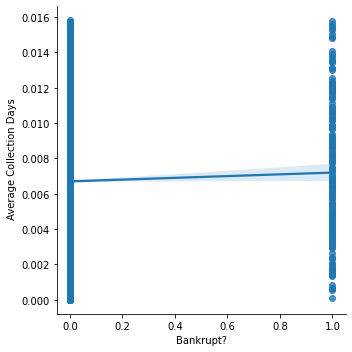

<Figure size 648x432 with 0 Axes>

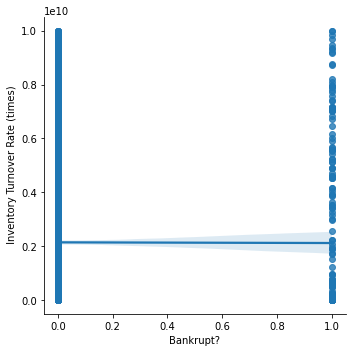

<Figure size 648x432 with 0 Axes>

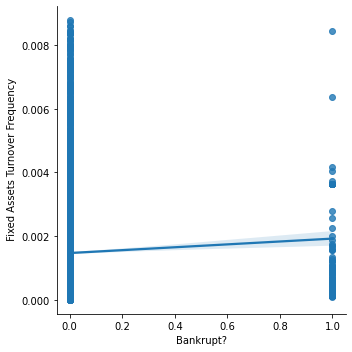

<Figure size 648x432 with 0 Axes>

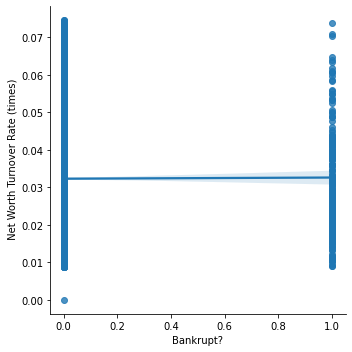

<Figure size 648x432 with 0 Axes>

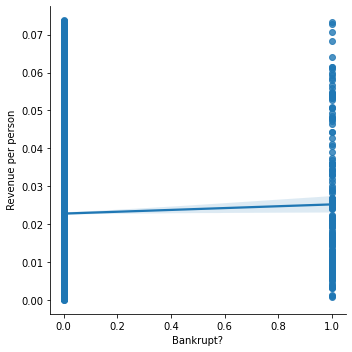

<Figure size 648x432 with 0 Axes>

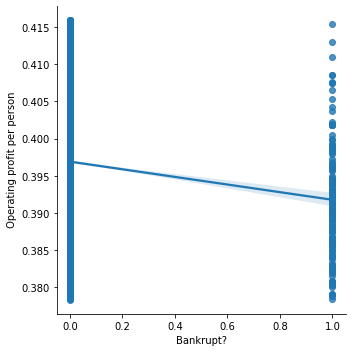

<Figure size 648x432 with 0 Axes>

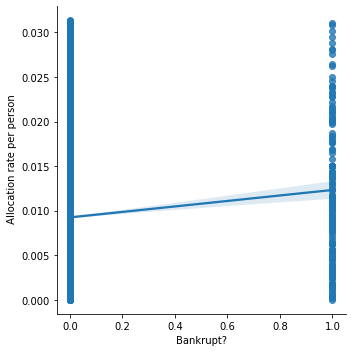

<Figure size 648x432 with 0 Axes>

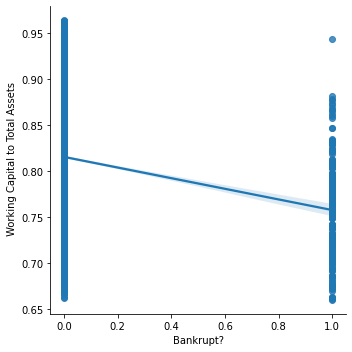

<Figure size 648x432 with 0 Axes>

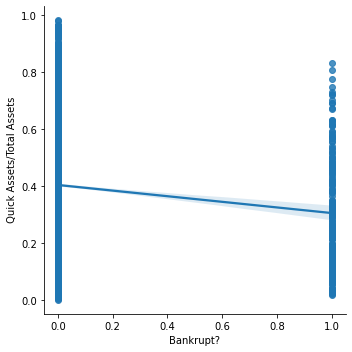

<Figure size 648x432 with 0 Axes>

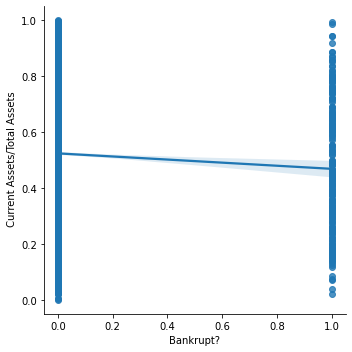

<Figure size 648x432 with 0 Axes>

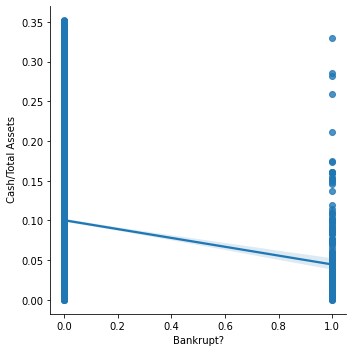

<Figure size 648x432 with 0 Axes>

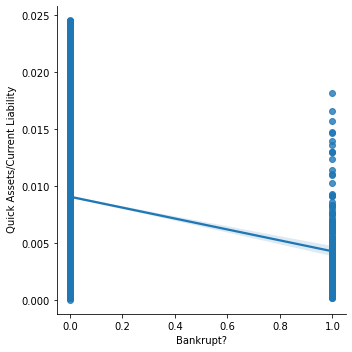

<Figure size 648x432 with 0 Axes>

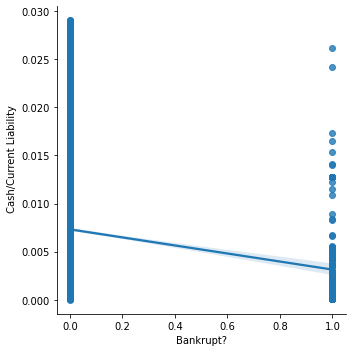

<Figure size 648x432 with 0 Axes>

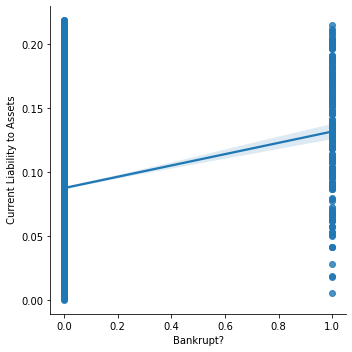

<Figure size 648x432 with 0 Axes>

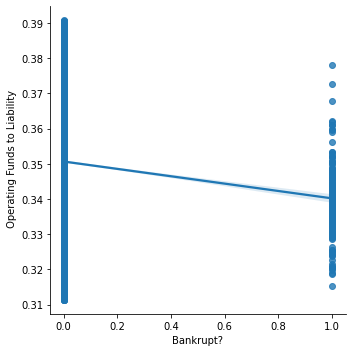

<Figure size 648x432 with 0 Axes>

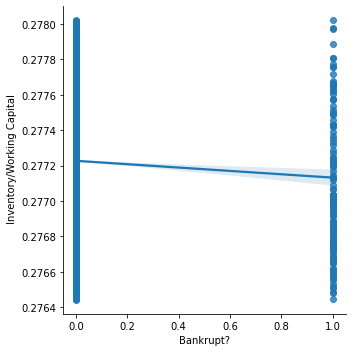

<Figure size 648x432 with 0 Axes>

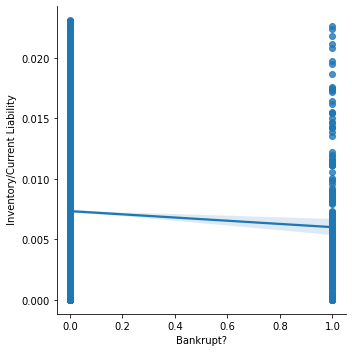

<Figure size 648x432 with 0 Axes>

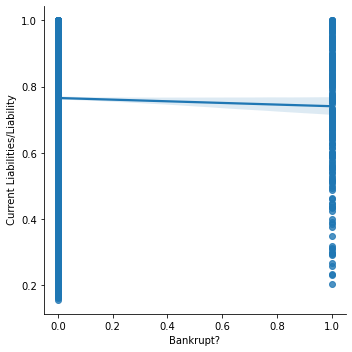

<Figure size 648x432 with 0 Axes>

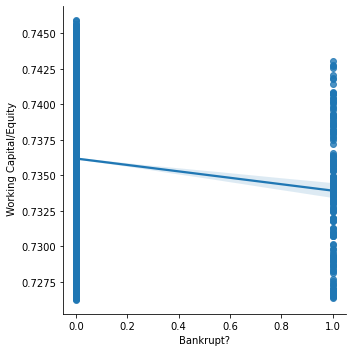

<Figure size 648x432 with 0 Axes>

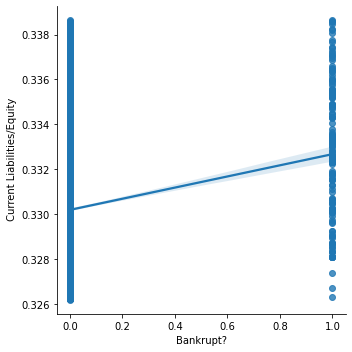

<Figure size 648x432 with 0 Axes>

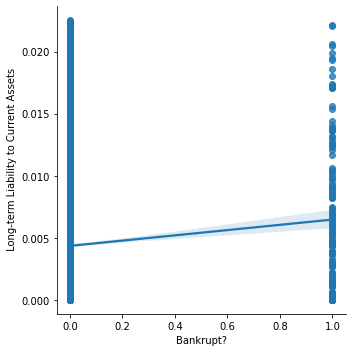

<Figure size 648x432 with 0 Axes>

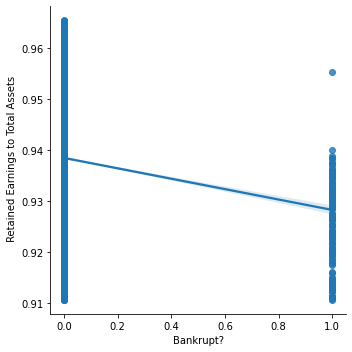

<Figure size 648x432 with 0 Axes>

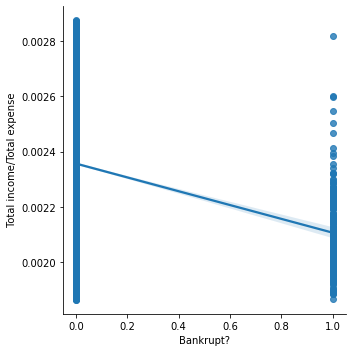

<Figure size 648x432 with 0 Axes>

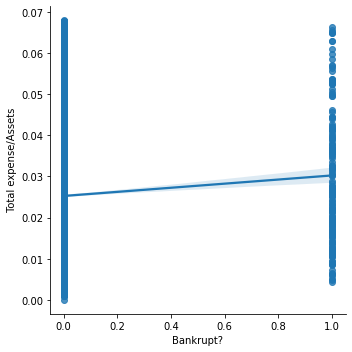

<Figure size 648x432 with 0 Axes>

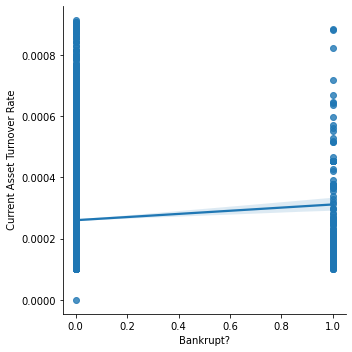

<Figure size 648x432 with 0 Axes>

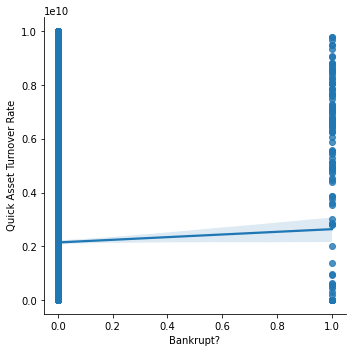

<Figure size 648x432 with 0 Axes>

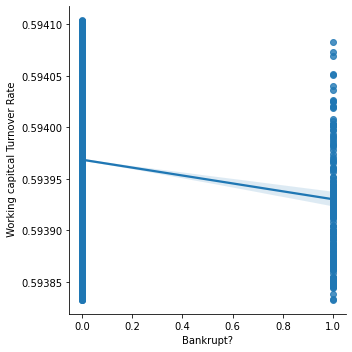

<Figure size 648x432 with 0 Axes>

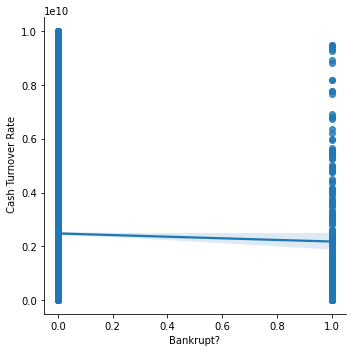

<Figure size 648x432 with 0 Axes>

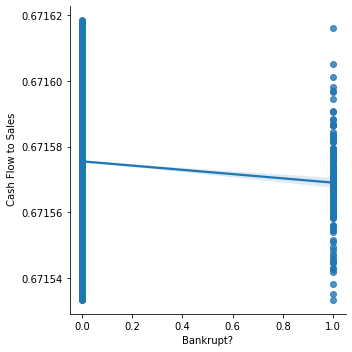

<Figure size 648x432 with 0 Axes>

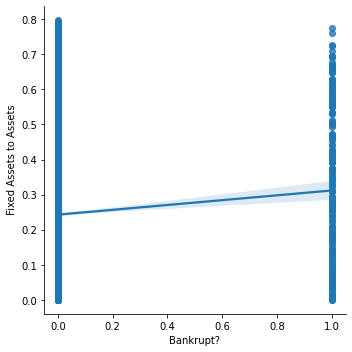

<Figure size 648x432 with 0 Axes>

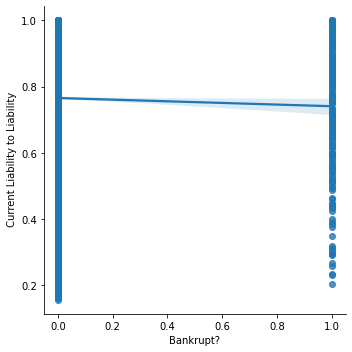

<Figure size 648x432 with 0 Axes>

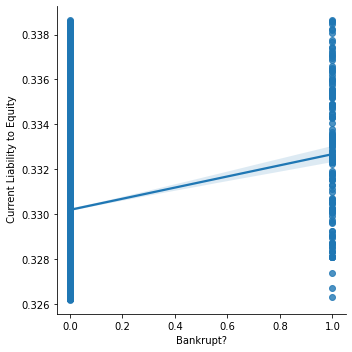

<Figure size 648x432 with 0 Axes>

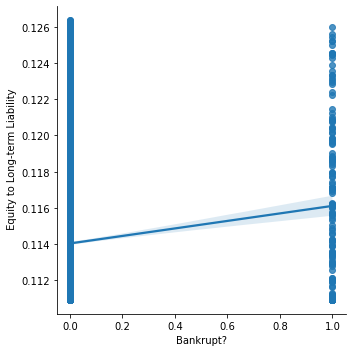

<Figure size 648x432 with 0 Axes>

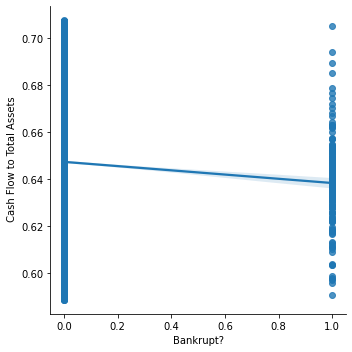

<Figure size 648x432 with 0 Axes>

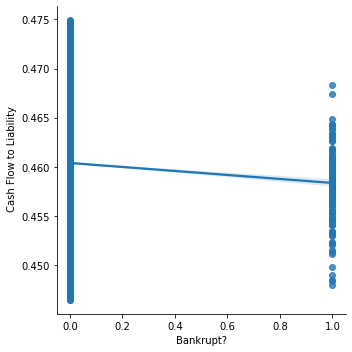

<Figure size 648x432 with 0 Axes>

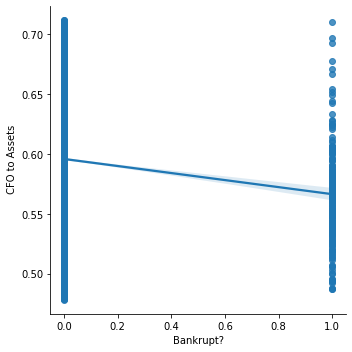

<Figure size 648x432 with 0 Axes>

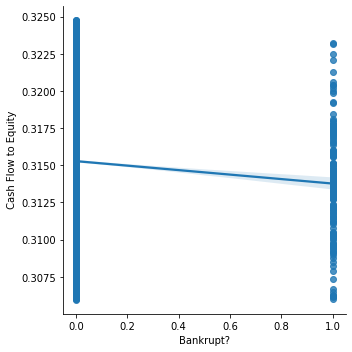

<Figure size 648x432 with 0 Axes>

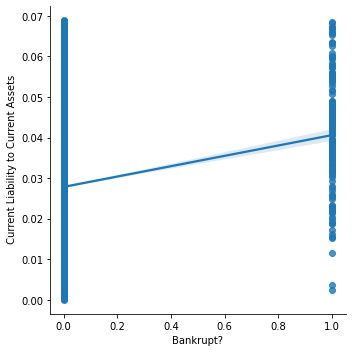

<Figure size 648x432 with 0 Axes>

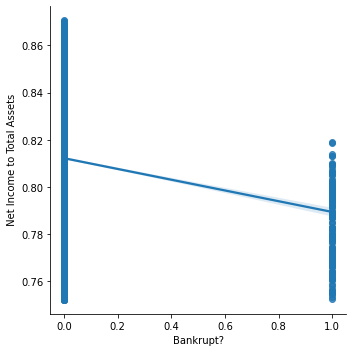

<Figure size 648x432 with 0 Axes>

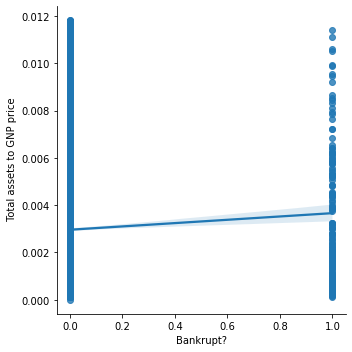

<Figure size 648x432 with 0 Axes>

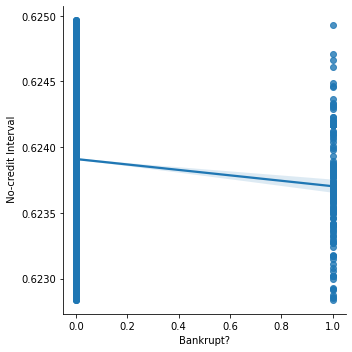

<Figure size 648x432 with 0 Axes>

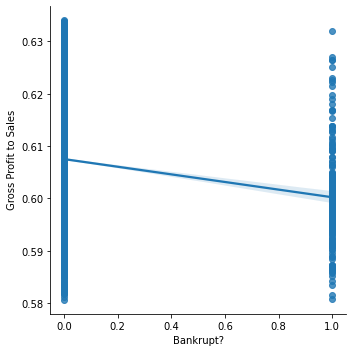

<Figure size 648x432 with 0 Axes>

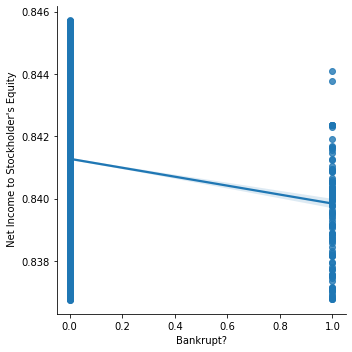

<Figure size 648x432 with 0 Axes>

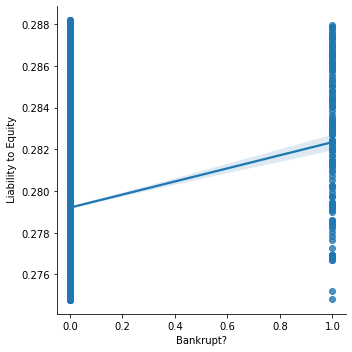

<Figure size 648x432 with 0 Axes>

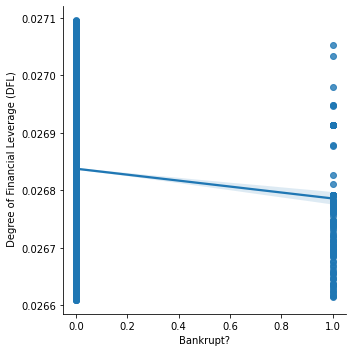

<Figure size 648x432 with 0 Axes>

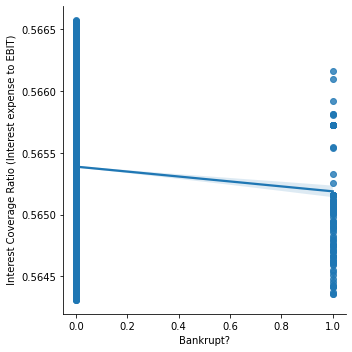

<Figure size 648x432 with 0 Axes>

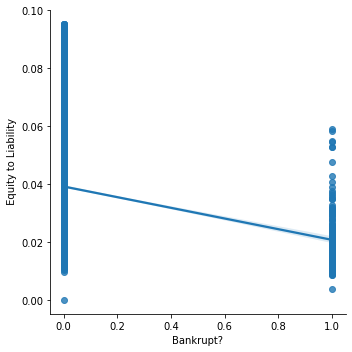

In [ ]:
for i in columns:
  fig = plt.figure(figsize=(9, 6))
  # ax = fig.gca()
  # df.boxplot(column = i, by = 'Bankrupt?', ax = ax)
  # ax.set_ylabel(i)
  sns.lmplot(x='Bankrupt?', y=i, data=df)
  plt.show()

**CONCLUSION--**

##<h2> Feature Selection

<h2>1. Using Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100,criterion='gini',class_weight='balanced',random_state= 21,n_jobs=-1)

In [ ]:
rf.fit(X,Y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [ ]:
feature_importance_df = pd.DataFrame(rf.feature_importances_)
feature_importance_df.shape

(93, 1)

In [ ]:
concatenated_imp_df = pd.concat([pd.DataFrame(X.columns),feature_importance_df],axis=1)
concatenated_imp_df.columns=['features','imp']
concatenated_imp_df = concatenated_imp_df.sort_values(by='imp',ascending=False)
#Chosing out top 25 columns
#final_df = concatenated_imp_df.head(25)
concatenated_imp_df.head(5)

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351


In [ ]:
concatenated_imp_df.tail(5)

,features,imp
47,Inventory Turnover Rate (times),0.003185
76,Current Liability to Liability,0.003177
86,No-credit Interval,0.003161
43,Inventory and accounts receivable/Net value,0.002677
40,Contingent liabilities/Net worth,0.001599


**These are top 5 and bottom 5 features.**

In [ ]:
concatenated_imp_df.iloc[:26]

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351
67,Retained Earnings to Total Assets,0.038452
39,Borrowing dependency,0.037289
9,Continuous interest rate (after tax),0.032081
36,Debt ratio %,0.026643
68,Total income/Total expense,0.025455


In [ ]:
# Chosing out top 25 columns
final_df = concatenated_imp_df.head(25)
final_df

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351
67,Retained Earnings to Total Assets,0.038452
39,Borrowing dependency,0.037289
9,Continuous interest rate (after tax),0.032081
36,Debt ratio %,0.026643
68,Total income/Total expense,0.025455


<h1> Using Information Gain.

In [ ]:
# create importances dataframe
from sklearn.feature_selection import mutual_info_classif
feature_importance = mutual_info_classif(X,Y)
feature_df = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(feature_importance)],axis=1)
feature_df.columns = ['Features','Importances']
feature_df = feature_df.sort_values(by='Importances',ascending=False)


In [ ]:
feature_df.tail(5)

,Features,Importances
49,Net Worth Turnover Rate (times),0.000000
47,Inventory Turnover Rate (times),0.000000
70,Current Asset Turnover Rate,0.000000
11,Research and development expense rate,0.000000
55,Current Assets/Total Assets,0.000000


In [ ]:
feature_df.head(5)

,Features,Importances
18,Persistent EPS in the Last Four Seasons,0.041784
42,Net profit before tax/Paid-in capital,0.040575
39,Borrowing dependency,0.037809
22,Per Share Net profit before tax (Yuan ¥),0.037322
88,Net Income to Stockholder's Equity,0.037087


In [ ]:
feature_df.iloc[40:50]

,Features,Importances
64,Working Capital/Equity,0.018767
59,Current Liability to Assets,0.018608
5,Operating Profit Rate,0.016973
58,Cash/Current Liability,0.016274
60,Operating Funds to Liability,0.015483
56,Cash/Total Assets,0.014979
26,Regular Net Profit Growth Rate,0.013742
25,After-tax Net Profit Growth Rate,0.013599
12,Cash flow rate,0.012929
4,Realized Sales Gross Margin,0.012553


In [ ]:
#Top 50 important features
final_features_df = feature_df.head(50)

**Taking out top 50 features from Information Gain Algo**

In [ ]:
list_rf = final_df['features'].values.tolist()
list_ig = final_features_df['Features'].values.tolist()


In [362]:
final_list = list((set(list_rf)).intersection(set(list_ig)))
temp_list = final_list.copy()
len(temp_list)

23

**We have taken the Intersection from the features of both Algo. We've reduced to 23 features**

In [363]:
final_features_df = df[final_list]
final_features_df.head()

,Continuous interest rate (after tax),Borrowing dependency,Debt ratio %,Net Income to Stockholder's Equity,Retained Earnings to Total Assets,Net Value Per Share (B),Liability to Equity,Total income/Total expense,Current Ratio,Per Share Net profit before tax (Yuan ¥),Quick Ratio,Non-industry income and expenditure/revenue,Net Income to Total Assets,Total debt/Total net worth,ROA(C) before interest and depreciation before interest,Net worth/Assets,ROA(B) before interest and depreciation after tax,ROA(A) before interest and % after tax,Net profit before tax/Paid-in capital,After-tax net Interest Rate,Net Value Per Share (C),Equity to Liability,Persistent EPS in the Last Four Seasons
0,0.781567,0.376271,0.207576,0.840115,0.931097,0.147950,0.281449,0.002022,0.002259,0.138736,0.001208,0.303466,0.796750,0.009273,0.476527,0.792424,0.527277,0.535543,0.137757,0.809312,0.147950,0.016469,0.214711
1,0.781506,0.376760,0.171176,0.839969,0.931065,0.182251,0.283846,0.002226,0.006016,0.169918,0.004039,0.303556,0.795297,0.012502,0.464291,0.828824,0.516730,0.538214,0.168962,0.809301,0.182251,0.020794,0.208944
2,0.781567,0.379093,0.207516,0.836774,0.931097,0.177911,0.281449,0.002060,0.011543,0.142803,0.005348,0.303466,0.774670,0.009273,0.426071,0.792484,0.472295,0.499019,0.148036,0.809312,0.193713,0.016474,0.180581
3,0.781567,0.379743,0.151465,0.840115,0.931097,0.154187,0.281721,0.002236,0.004194,0.148603,0.002896,0.303350,0.796750,0.009572,0.399844,0.848535,0.457733,0.535543,0.147561,0.809312,0.154187,0.023982,0.193722
4,0.781550,0.375025,0.106509,0.839973,0.913850,0.167502,0.278514,0.002224,0.006022,0.168412,0.003727,0.303475,0.795016,0.005150,0.465022,0.893491,0.522298,0.538432,0.167461,0.809304,0.167502,0.035490,0.212537


In [364]:
final_list.append('Bankrupt?')
final_list

[' Continuous interest rate (after tax)',
 ' Borrowing dependency',
 ' Debt ratio %',
 " Net Income to Stockholder's Equity",
 ' Retained Earnings to Total Assets',
 ' Net Value Per Share (B)',
 ' Liability to Equity',
 ' Total income/Total expense',
 ' Current Ratio',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Quick Ratio',
 ' Non-industry income and expenditure/revenue',
 ' Net Income to Total Assets',
 ' Total debt/Total net worth',
 ' ROA(C) before interest and depreciation before interest',
 ' Net worth/Assets',
 ' ROA(B) before interest and depreciation after tax',
 ' ROA(A) before interest and % after tax',
 ' Net profit before tax/Paid-in capital',
 ' After-tax net Interest Rate',
 ' Net Value Per Share (C)',
 ' Equity to Liability',
 ' Persistent EPS in the Last Four Seasons',
 'Bankrupt?']

In [365]:
final_company_df = df[final_list]
final_company_df

,Continuous interest rate (after tax),Borrowing dependency,Debt ratio %,Net Income to Stockholder's Equity,Retained Earnings to Total Assets,Net Value Per Share (B),Liability to Equity,Total income/Total expense,Current Ratio,Per Share Net profit before tax (Yuan ¥),Quick Ratio,Non-industry income and expenditure/revenue,Net Income to Total Assets,Total debt/Total net worth,ROA(C) before interest and depreciation before interest,Net worth/Assets,ROA(B) before interest and depreciation after tax,ROA(A) before interest and % after tax,Net profit before tax/Paid-in capital,After-tax net Interest Rate,Net Value Per Share (C),Equity to Liability,Persistent EPS in the Last Four Seasons,Bankrupt?
0,0.781567,0.376271,0.207576,0.840115,0.931097,0.147950,0.281449,0.002022,0.002259,0.138736,0.001208,0.303466,0.796750,0.009273,0.476527,0.792424,0.527277,0.535543,0.137757,0.809312,0.147950,0.016469,0.214711,1
1,0.781506,0.376760,0.171176,0.839969,0.931065,0.182251,0.283846,0.002226,0.006016,0.169918,0.004039,0.303556,0.795297,0.012502,0.464291,0.828824,0.516730,0.538214,0.168962,0.809301,0.182251,0.020794,0.208944,1
2,0.781567,0.379093,0.207516,0.836774,0.931097,0.177911,0.281449,0.002060,0.011543,0.142803,0.005348,0.303466,0.774670,0.009273,0.426071,0.792484,0.472295,0.499019,0.148036,0.809312,0.193713,0.016474,0.180581,1
3,0.781567,0.379743,0.151465,0.840115,0.931097,0.154187,0.281721,0.002236,0.004194,0.148603,0.002896,0.303350,0.796750,0.009572,0.399844,0.848535,0.457733,0.535543,0.147561,0.809312,0.154187,0.023982,0.193722,1
4,0.781550,0.375025,0.106509,0.839973,0.913850,0.167502,0.278514,0.002224,0.006022,0.168412,0.003727,0.303475,0.795016,0.005150,0.465022,0.893491,0.522298,0.538432,0.167461,0.809304,0.167502,0.035490,0.212537,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.781588,0.373823,0.124618,0.840359,0.925611,0.175045,0.279606,0.002266,0.010451,0.172102,0.005457,0.303510,0.799927,0.006655,0.493687,0.875382,0.543230,0.539468,0.171111,0.809331,0.175045,0.029890,0.216602,0
6815,0.781586,0.372505,0.099253,0.840306,0.932629,0.181324,0.278132,0.002288,0.009259,0.172780,0.006741,0.303520,0.799748,0.004623,0.475162,0.900747,0.524172,0.538269,0.171805,0.809327,0.181324,0.038284,0.216697,0
6816,0.781546,0.369637,0.038939,0.840138,0.932000,0.199570,0.275789,0.002239,0.016270,0.173232,0.012249,0.303512,0.797778,0.001392,0.472725,0.961061,0.520638,0.533744,0.172287,0.809317,0.199612,0.052838,0.210929,0
6817,0.781663,0.369649,0.086979,0.841084,0.939613,0.213392,0.277547,0.002395,0.012782,0.185584,0.007256,0.303498,0.811808,0.003816,0.506264,0.913021,0.554045,0.559911,0.182498,0.809399,0.213392,0.044009,0.228326,0


In [366]:
X1 =final_company_df.drop('Bankrupt?', axis=1)
Y1 = final_company_df['Bankrupt?']


In [ ]:
def dist_and_box(list_):
  for i in list_ :
      plt.figure(figsize=(12,6))
      plt.subplot(1, 2, 1)
      fig = sns.distplot(X1[i])
      fig.set_xlabel(i)     
      
      plt.subplot(1, 2, 2)
      fig = sns.boxplot(y=X1[i])
      fig.set_title('')
      fig.set_ylabel(i)

      plt.show()


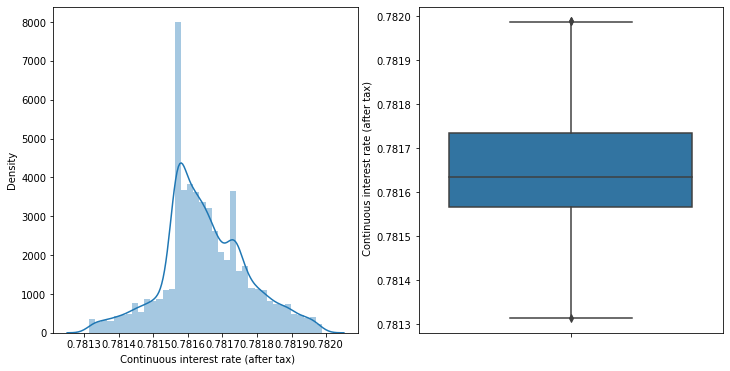

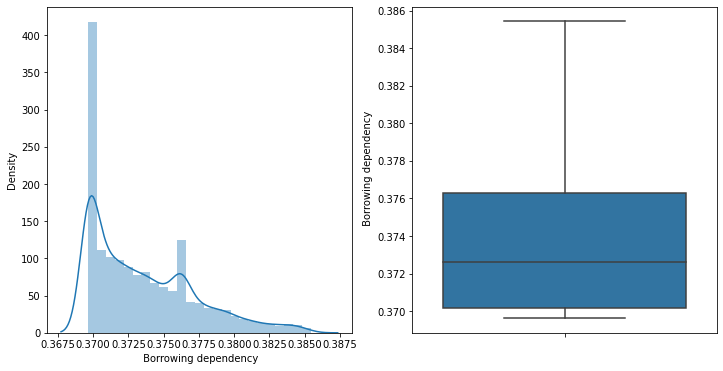

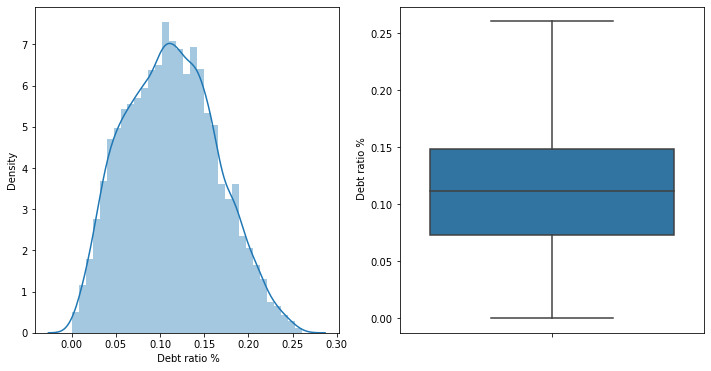

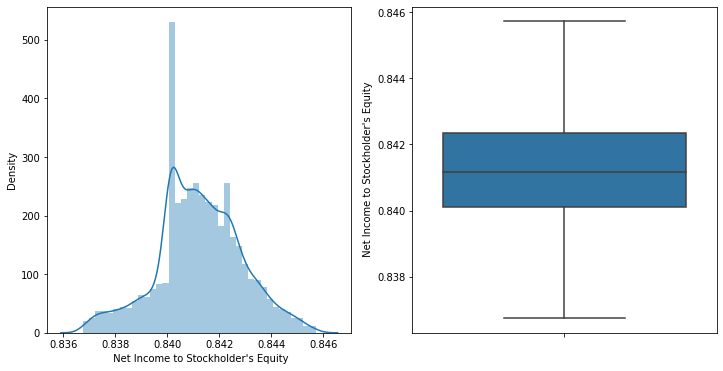

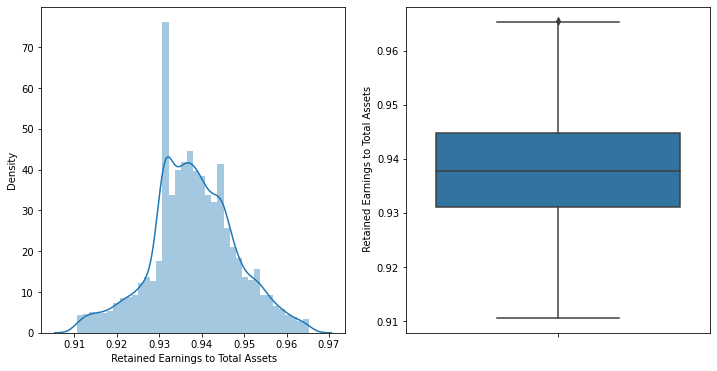

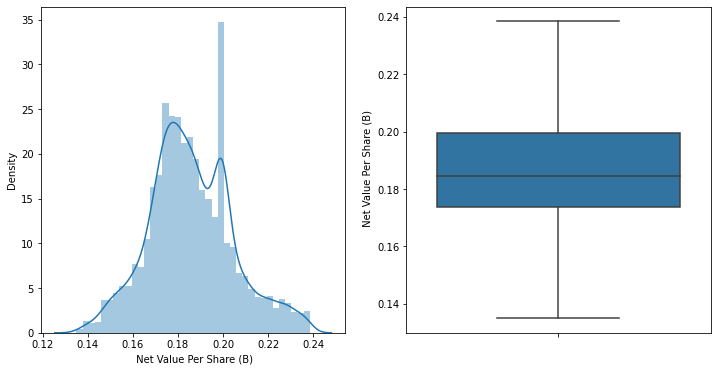

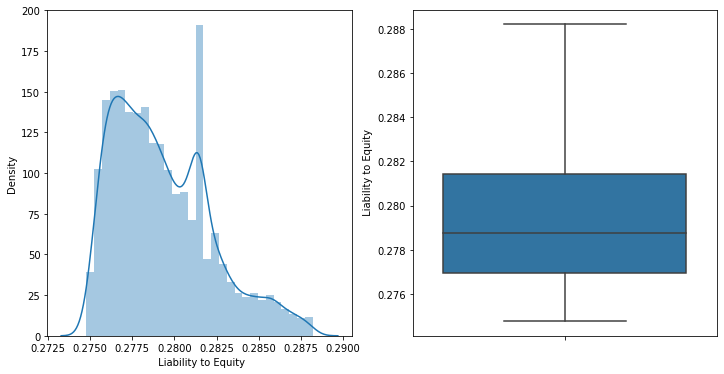

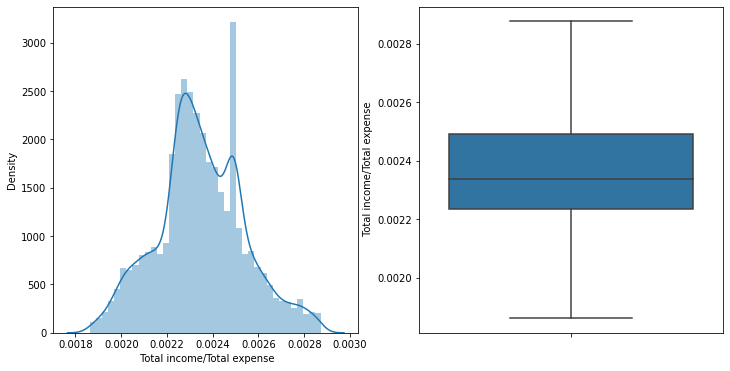

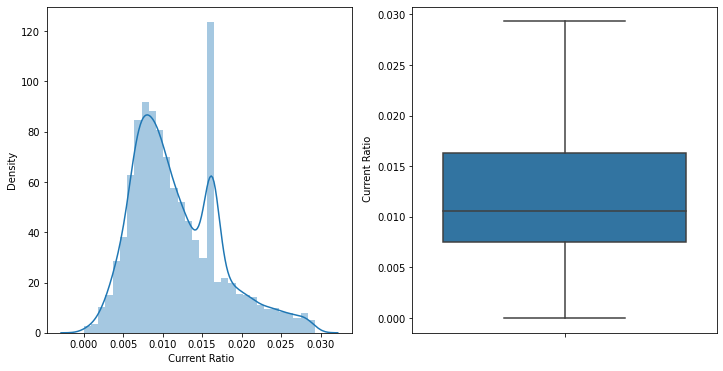

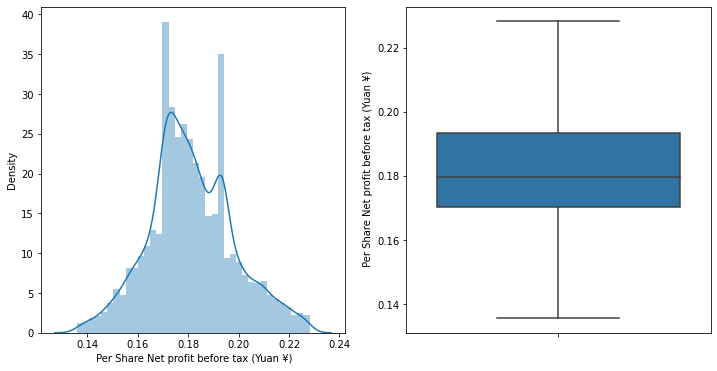

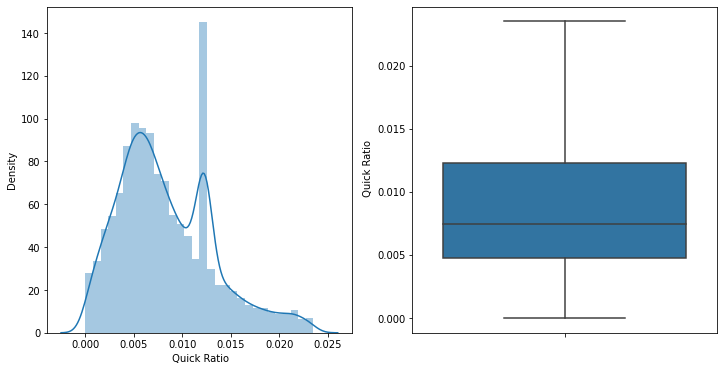

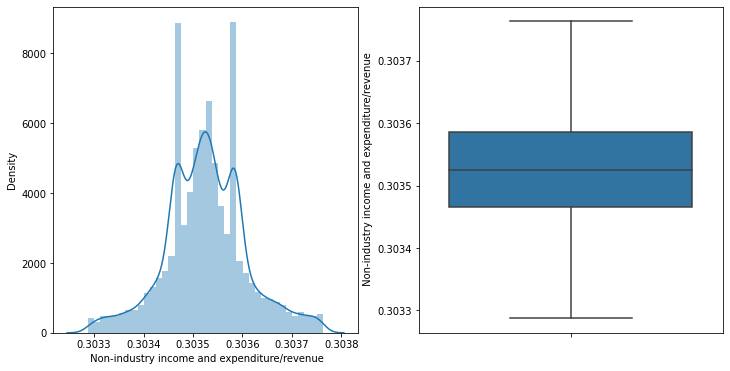

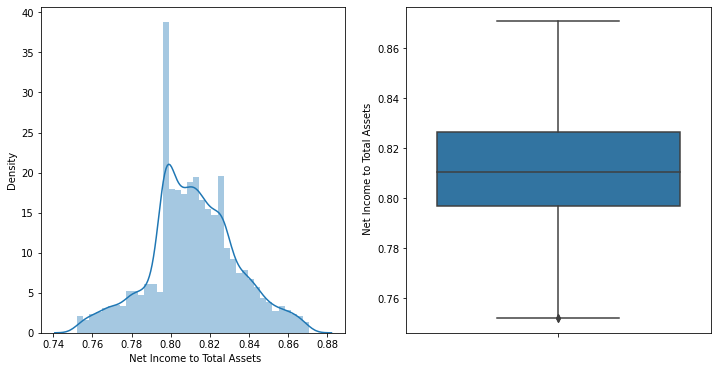

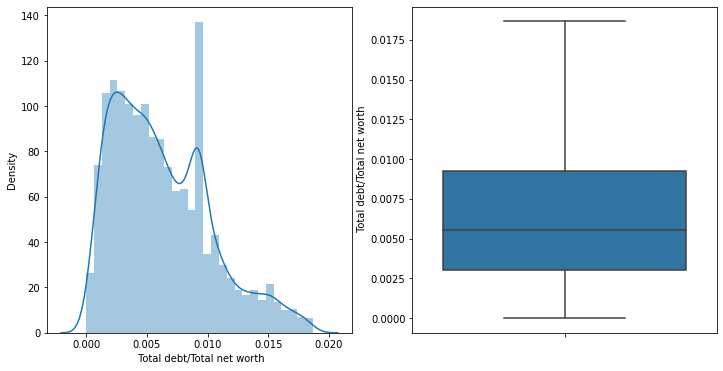

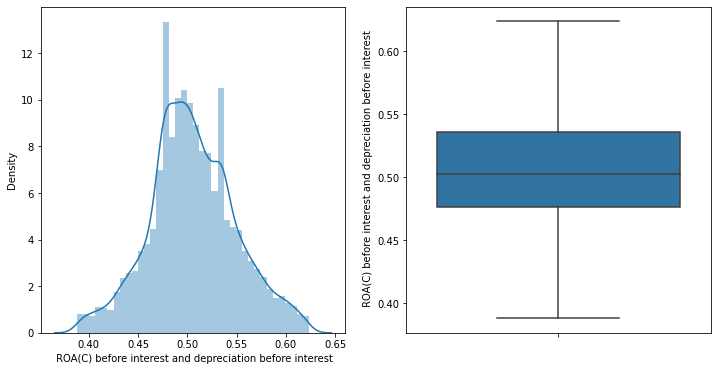

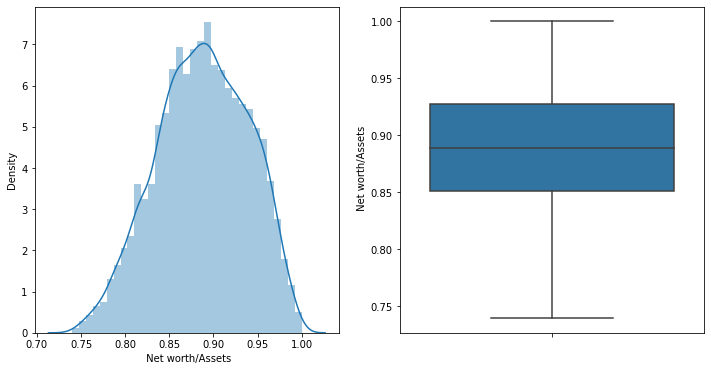

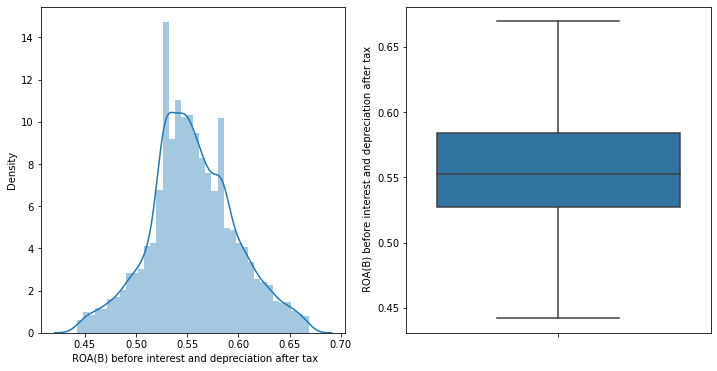

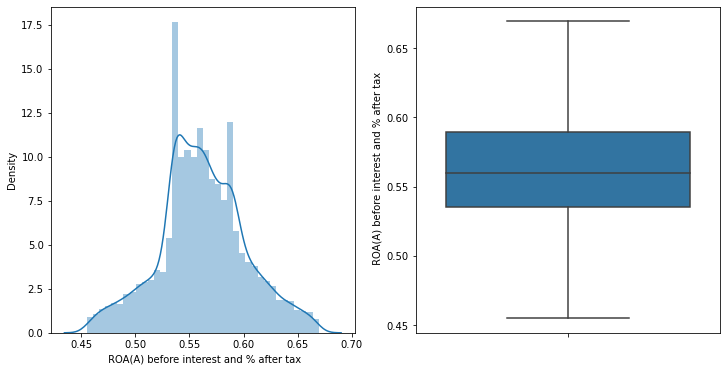

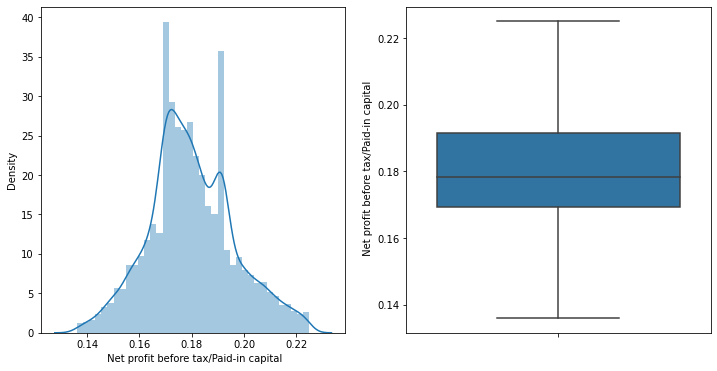

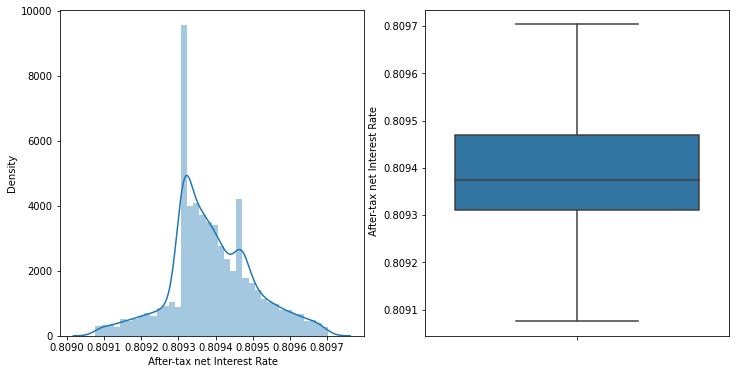

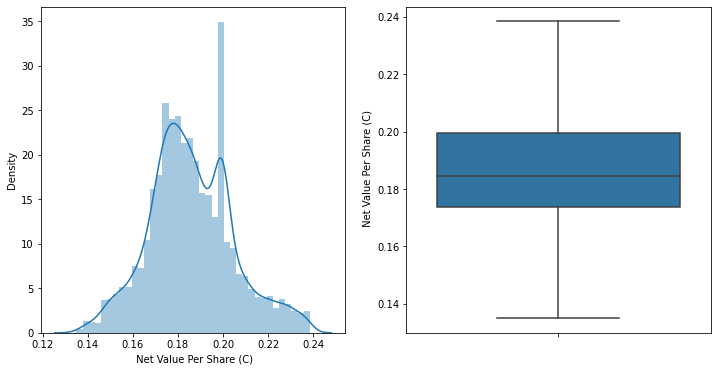

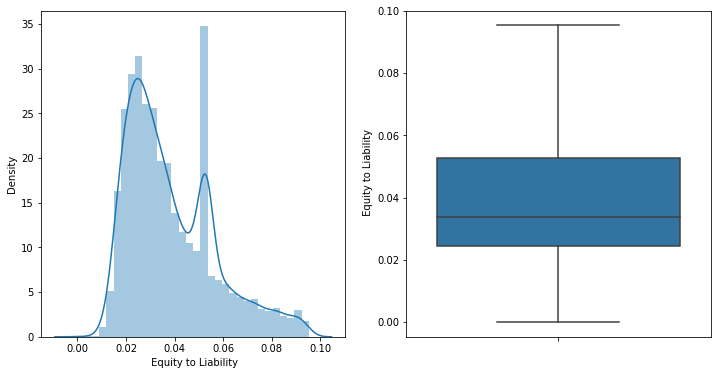

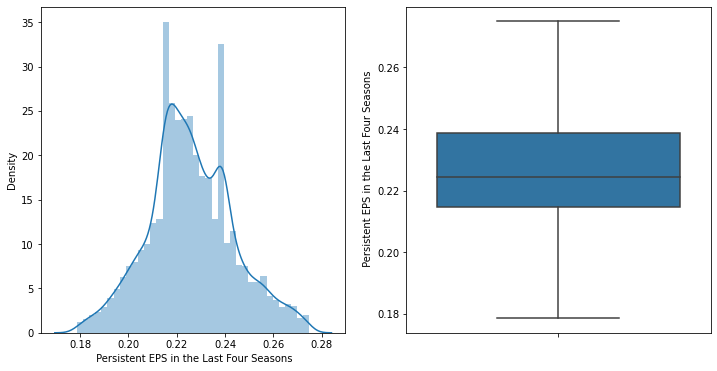

In [367]:
dist_and_box(temp_list)

**Above are the pair plot with Dependent Variable and final features after feature selection.**

<h2> Heatmap to Visualize Correlation.

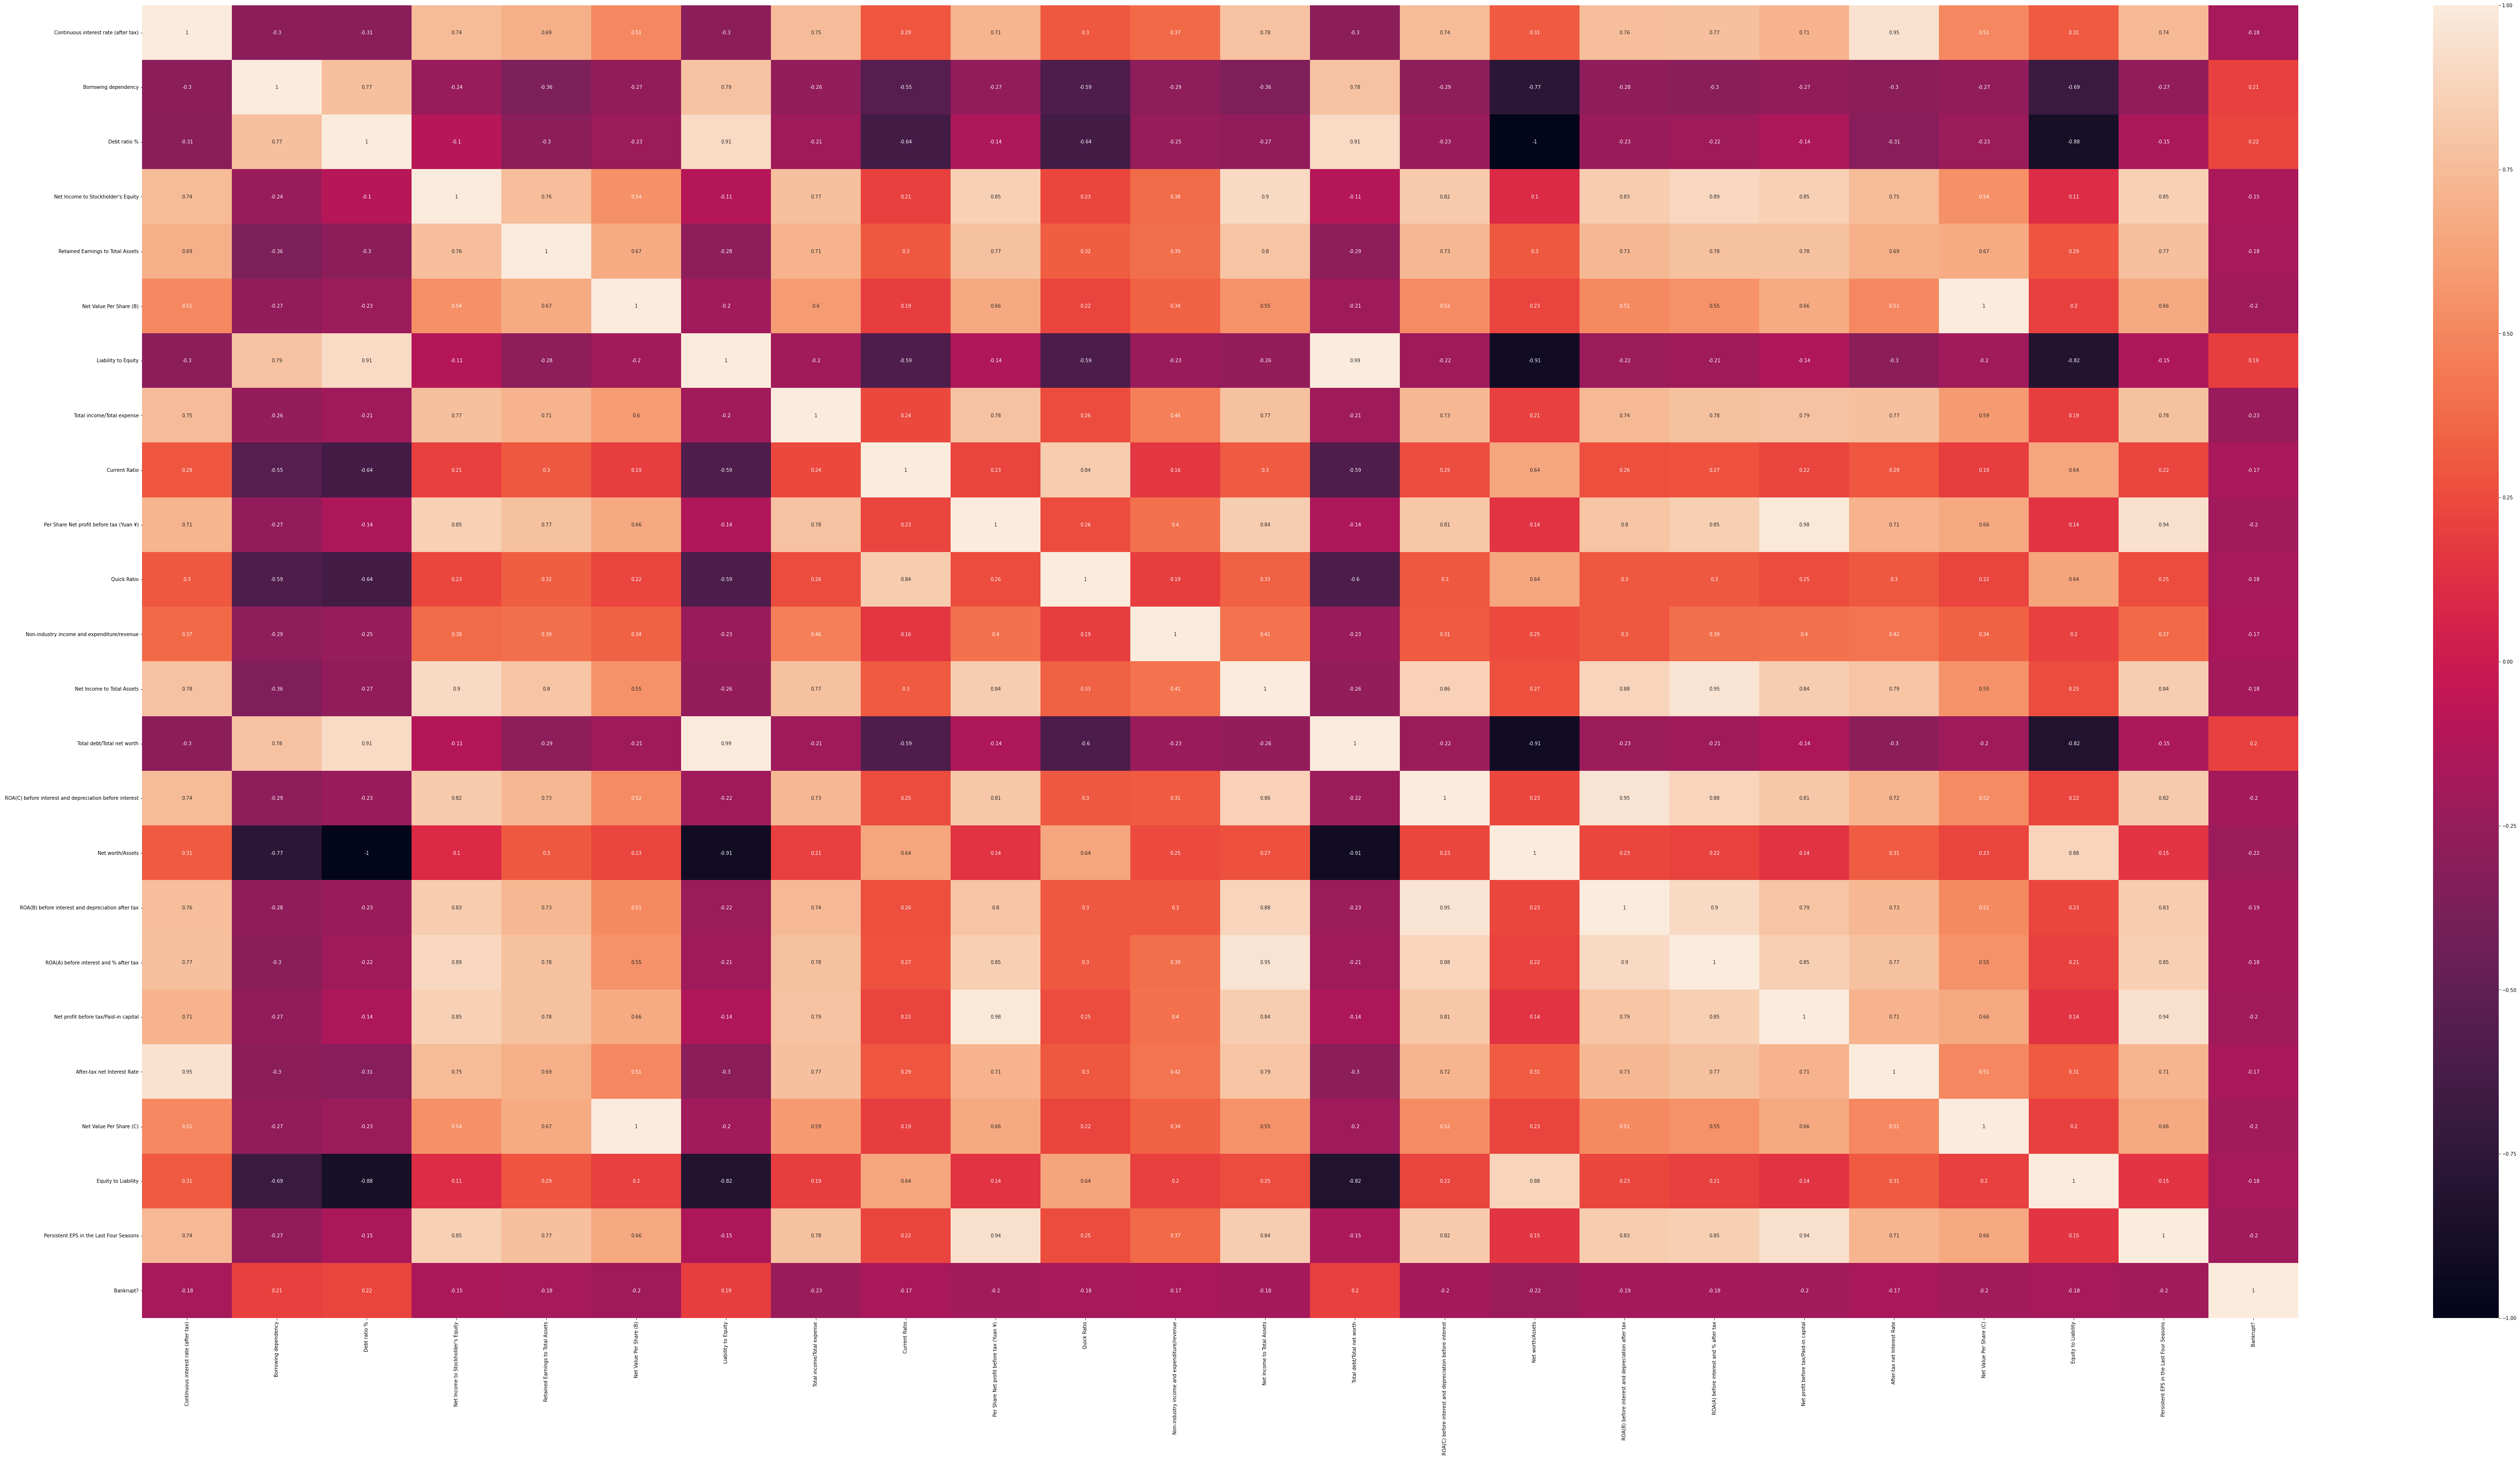

In [368]:
fig, ax = plt.subplots(figsize=(100,50))
sns.heatmap(final_company_df.corr(), annot=True,ax = ax)

<h2> We can see strong among few features.

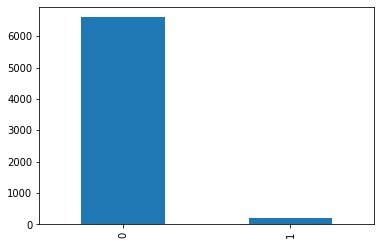

In [369]:
final_company_df['Bankrupt?'].value_counts().plot(kind = 'bar')

Dependent Variable has high class imbalance in the data.

In [370]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

##<h2> PCA with Scree Plot (ToDo)

##<h2> Model Building

In [ ]:
metric_report = pd.DataFrame(columns = ['logistic_regression','random_forest','easy_ensemble','SVM','gaussian_naive_bayes','KNN','XGBOOST'], index = ['test_acc','train_acc','test_precision','train_precision','test_recall','train_recall','test_f1-score','train_f1-score','test_auc','train_auc'])

In [ ]:

# fitting the logistic regression model
lr=LogisticRegression(penalty='l1',solver='saga',class_weight='balanced',C=0.01)
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))

In [ ]:

#creating a data frame of the coefficients and column names
coef_df=pd.DataFrame(zip(vif_final.columns,lr.coef_.reshape(-1,1)),columns=['column','coeff'])
#storing the columns with non zero coefficients
columns_after_vif_l1=[x for x in coef_df[coef_df.coeff!=0]['column']]
len(columns_after_vif_l1)

In [ ]:
##PValue with OLS


#scaling the data
scaler=StandardScaler()
X_2=scaler.fit_transform(X_1)

In [ ]:

model = sm.OLS(y, X_2)
results = model.fit()
#print(results.summary())

In [ ]:
p_val_ols=pd.DataFrame(zip(X_1.columns,results.pvalues),columns=['column','p_values'])
columns_based_on_p_values_ols=[x for x in p_val_ols[p_val_ols.p_values<=0.05]['column']]
len(columns_based_on_p_values_ols)

In [ ]:
#information gain

# create importances dataframe
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_classif(X_1,y)
importances_df = pd.concat([pd.DataFrame(X_1.columns),pd.DataFrame(importances)],axis=1)
importances_df.columns = ['Features','Importances']
importances_df = importances_df.sort_values(by='Importances',ascending=False)
# Top 30 important features
new_features = importances_df.head(30)

In [ ]:
feature_list = new_features.Features.tolist()
feature_list

In [ ]:
##QUASI
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.01)
sel.fit(X_1)

sum(sel.get_support())

print(
    len([
        i for i in X_1.columns
        if i not in X_1.columns[sel.get_support()]
    ]))

[i for i in X_1.columns if i not in X_1.columns[sel.get_support()]]

segregated_list = [i for i in X_1.columns if i in X_1.columns[sel.get_support()]]
len(segregated_list)

Feature selection </br>
Random forest compared with information gain(TOP 30 features)

In [ ]:
rf = RandomForestClassifier(n_estimators=200,criterion='gini',class_weight='balanced',random_state= 21,n_jobs=-1)

In [ ]:
rf.fit(X_1,y)

In [ ]:
imp_df = pd.DataFrame(rf.feature_importances_)
imp_df.shape

In [ ]:
feature_imp_df = pd.concat([pd.DataFrame(X_1.columns),imp_df],axis=1)
feature_imp_df.columns=['features','imp']
feature_imp_df = feature_imp_df.sort_values(by='imp',ascending=False)
feature_imp_df = feature_imp_df.head(30)

In [ ]:
feature_list2 = feature_imp_df.features.tolist()


In [ ]:

# Function to check number similarity of two lists
def list_similarity(l1,l2):
  '''This function return the number of common elements between two given lists 
  and a list of those common elements '''
  list_bool = []
  for elem1 in l1:
    for elem2 in l2: 
      if elem1==elem2:
        list_bool.append(True)
  print('No of commom elements= ',sum(list_bool))
  return list(set(l1).intersection(set(l2)))

In [ ]:

# Check feature similarity between two feature lists obtained above
similar_list = list_similarity(feature_list,feature_list2)

In [ ]:
## Correlation
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(x, 0.8)
print('correlated features: ', len(set(corr_features)) )

lista = list(corr_features)
lista.append('Bankrupt?')

set(corr_features)
len(corr_features)

#EDA

In [ ]:
df2 = df.iloc[:,1:].copy()
X = df2
Y = df['Bankrupt?']

In [ ]:
def plotter():
  for var in columns_after_vif :
      plt.figure(figsize=(15,6))
      plt.subplot(1, 2, 1)
      fig = sns.boxplot(y=df[var])
      fig.set_title('')
      fig.set_ylabel(var)
      
      plt.subplot(1, 2, 2)
      fig = sns.distplot(df[var].dropna())
      fig.set_xlabel(var)

      plt.show()

plotter()